In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import random
import numpy as np
from tqdm import tqdm
import pandas as pd
from scipy import ndimage
from scipy.ndimage import zoom
import gc
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch.backends.cudnn as cudnn
from models.sfcn import *
from models.resnet import *
from models.inception_resnet_v2 import *
from models.densenet import *
from models.custom_net import *
from models.shallow_net2 import *
import types
from scipy.stats import pearsonr, spearmanr
import torchio as tio
from datetime import datetime
import wandb
from models.ranking_loss import *

In [3]:
RANDOM_SEED = 551

In [4]:
# control randomness
def set_seed(random_seed=551):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    np.random.seed(random_seed)
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(random_seed)

In [5]:
def load_data(img_dir, label_dir, label_name, std=False, norm=True):
    df = pd.read_csv(label_dir, index_col=0)[label_name]
    filenames = df.index
    images = []
    for i, index in enumerate(filenames):
        file_name = img_dir + index + '.npy'
        img = np.load(file_name)
        x, y, z = img.shape
        if std:
            m = np.mean(img)
            s = np.std(img)
            img = (img - m) / s
        if norm:
            img = (img - img.min()) / (img.max() - img.min())
        img = img.reshape((1, x, y, z))
        images.append(img)
    return images, df

In [6]:
# augmentation
def get_augmentation_transform():
    random_rotate = tio.RandomAffine(scales=(1.0, 1.0),
                                     degrees=12,)
    random_flip = tio.RandomFlip(axes='LR',
                                 flip_probability=0.5)
    random_shift = tio.RandomAffine(scales=(1.0, 1.0),
                                    degrees=0,
                                    translation=(20,20,20))
    compose = tio.transforms.Compose([random_rotate, random_flip, random_shift])
    augment = tio.transforms.OneOf([random_rotate, random_flip, random_shift, compose])
    return augment

In [7]:
class NeckDataset(Dataset):
    def __init__(self, X=None, y=None, transform=None, lds=False, lds_kernel='gaussian', lds_ks=5, lds_sigma=2):
        self.X = X
        self.y = y.values
        self.transform = transform
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        image = self.X[idx]
        label = np.array([self.y[idx]]).astype('float16')
        if self.transform is not None:
            image = self.transform(image)
        return [image, label]

In [8]:
def train(model, train_loader, lr, weight_decay, optim_class=optim.AdamW, scheduler=None, sorter='sodeep/weights/best_model_gruc.pth.tar'):
    criterion = rank_difference_loss(sorter)
#     criterion = nn.HuberLoss()
    criterion1 = nn.L1Loss()
    criterion2 = nn.MSELoss()
        
    optimizer = optim_class(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    total_loss, total_mae_loss, total_mse_loss = 0, 0, 0
    preds, truths = np.array([]), np.array([])
    
    model.train()
    for inputs, labels in tqdm(train_loader):              
        inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)
        optimizer.zero_grad()

        output = model(inputs)
        
        pred = output.detach().cpu().numpy()
        truth = labels.detach().cpu().numpy()
        preds = np.append(preds, pred.reshape(pred.size), axis=0)
        truths = np.append(truths, truth.reshape(truth.size), axis=0)
        
        loss = criterion(output, labels)
        mae_loss = criterion1(output, labels)
        mse_loss = criterion2(output, labels)
#         loss.backward()
        mae_loss.backward()
#         mse_loss.backward()
        
        optimizer.step()
        if scheduler:
            scheduler.step()
        
        total_loss += loss.data.item()
        total_mae_loss += mae_loss.data.item()
        total_mse_loss += mse_loss.data.item()
        
        gc.collect()
        torch.cuda.empty_cache()
        
    return preds, truths, total_loss, total_mae_loss, total_mse_loss

In [9]:
def valid(model, valid_loader, sorter='sodeep/weights/best_model_gruc.pth.tar'):
    criterion = rank_difference_loss(sorter)
#     criterion = nn.HuberLoss()
    criterion1 = nn.L1Loss()
    criterion2 = nn.MSELoss()
    
    total_loss, total_mae_loss, total_mse_loss = 0, 0, 0
    preds, truths = np.array([]), np.array([])
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader):
            inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)

            output = model(inputs)
            
            pred = output.detach().cpu().numpy()
            truth = labels.detach().cpu().numpy()
            preds = np.append(preds, pred.reshape(pred.size), axis=0)
            truths = np.append(truths, truth.reshape(truth.size), axis=0)

            loss = criterion(output, labels)
            mae_loss = criterion1(output, labels)
            mse_loss = criterion2(output, labels)
            
            total_loss += loss.data.item()
            total_mae_loss += mae_loss.data.item()
            total_mse_loss += mse_loss.data.item()
        
    return preds, truths, total_loss, total_mae_loss, total_mse_loss

In [10]:
# label_name = 'Cerebral WM Hypointensities* Total Percent Of Icv'
# label_name = 'FL_WMH_VOL_icv'
# label_name = 'Cerebral WM Hypointensities* Total Volume'
label_name = 'FL_WMH_VOL_mL'
train_img_dir = 'img_npy/'
train_label_dir = 'labels/traindata_final.csv'
test_img_dir = 'test_np/'
test_label_dir = 'labels/testdata_final.csv'

In [11]:
weight_decay = 0.01
lr = 0.0001
epochs = 30
batch_size = 16
optimizer = optim.AdamW
dropout_rate = 0.6
# scheduler = optim.lr_scheduler.MultiplicativeLR(optimizer=optimizer,
#                                                lr_lambda=lambda epoch: 0.3 ** epoch)

In [12]:
aug = True

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 1


In [14]:
# load data
train_X, train_y = load_data(train_img_dir, train_label_dir, label_name, std=False, norm=True)  # std=False, norm=True
test_X, test_y = load_data(test_img_dir, test_label_dir, label_name, std=False, norm=True)

In [15]:
if aug:
    # initialize seed
    set_seed()

    # train / test split
    X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, test_size=0.2)

    # validation set
    valid_set = NeckDataset(X_val, y_val)
    valid_loader = DataLoader(valid_set, batch_size=batch_size, num_workers=16)

    # test set
    test_set = NeckDataset(test_X, test_y)
    test_loader = DataLoader(test_set, batch_size=batch_size, num_workers=16)

    print(len(X_train), len(y_train), len(valid_set), len(test_set))
else:
    dataset = NeckDataset(train_X, train_y)

    set_seed()
    train_set, valid_set = train_test_split(dataset, test_size=0.2)
    train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=16)
    valid_loader = DataLoader(train_set, batch_size=batch_size, num_workers=16)

    test_set = NeckDataset(test_X, test_y)
    test_loader = DataLoader(test_set, batch_size=batch_size, num_workers=16)

    print(len(train_set), len(valid_set), len(test_set))

643 643 161 171


In [16]:
# use SEBlock
class SEBlock(nn.Module):
    
    def __init__(self, in_channels, r=16):
        super(SEBlock, self).__init__()
        self.squeeze = nn.AdaptiveAvgPool3d(1)
        self.excitation = nn.Sequential(
            nn.Linear(in_channels, in_channels//r),
            nn.ReLU(),
            nn.Linear(in_channels//r, in_channels),
            nn.Sigmoid())
        
    def forward(self, x):
        x = self.squeeze(x)
        x = x.view(x.size(0), -1)
        x = self.excitation(x)
        x = x.view(x.size(0), x.size(1), 1, 1, 1)
        return x
    

def forward(self, x):
    x = self.feature_extractor(x)
    # add SEBlock
    x = self.seblock(x)*x
    x = self.classifier(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)
    return x

In [17]:
set_seed()

#### model: simple net####
model = SFCN()
if dropout_rate != 0.5:
    model.classifier.dropout.p = dropout_rate
###########################

# #### model: simple net, leakyReLU added ####
# model = SFCN()
# if dropout_rate != 0.5:
#     model.classifier.dropout.p = dropout_rate
# model.fc.add_module('relu', nn.LeakyReLU())
# ###########################

# #### model: simple SE net ####
# model = SFCN()
# if dropout_rate != 0.5:
#     model.classifier.dropout.p = dropout_rate
# model.seblock = SEBlock(64)
# model.forward = types.MethodType(forward, model)
# ##############################

# #### model: resnet26 ####
# model = resnet26(in_channels=1, num_classes=1)
# #########################

# #### model: inception-resnet-v2 ####
# model = inception_resnet_v2(in_channels=1, num_classes=1)
# ####################################

# #### model: densenet ####
# model = densenet(121, in_channels=1, num_classes=1)
# #########################

model.to(device)
wandb.init(project='20230130-WMHvol',
           config={"model": "sfcn", "dropout": dropout_rate, 
                   "lr": lr, "weight_decay": weight_decay, "epochs": epochs, "batch_size": batch_size,
                   "cost_function": "l1_loss"},
           notes="FLAIR, augmentation")
wandb.watch(model)

best_rec, best_p, best_s = 0, 0, 0   # best_rec: best validation ranking loss

set_seed()
for epoch in range(epochs):
    print('# Epoch %d / %d'%(epoch + 1, epochs))    
    if aug:
        augment = get_augmentation_transform()
        train_set = NeckDataset(X_train, y_train, transform=augment)
        train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=16)

    # log image to check if augmentation is same for every experiment
    img = wandb.Image(np.max(train_set[0][0].squeeze(), axis=1), caption="Coronal MIP")

    preds_t, truths_t, rloss_t, mae_t, mse_t = train(model, train_loader, lr, weight_decay, optimizer)
    preds_v, truths_v, rloss_v, mae_v, mse_v = valid(model, valid_loader)

    train_p, _ = pearsonr(preds_t, truths_t)
    train_s, _ = spearmanr(preds_t, truths_t)
    train_mae = mae_t / len(train_loader)
    train_mse = mse_t / len(train_loader)
    train_rloss = rloss_t / len(train_loader)

    valid_p, _ = pearsonr(preds_v, truths_v)
    valid_s, _ = spearmanr(preds_v, truths_v)
    valid_mae = mae_v / len(valid_loader)
    valid_mse = mse_v / len(valid_loader)
    valid_rloss = rloss_v / len(valid_loader)

    if epoch < 1 or best_rec > valid_mae:
        best_rec = valid_mae
        torch.save(model.state_dict(), 'pretrained/230130_flairWMHvol_sfcn+mae_best')
    if best_p < valid_p:
        best_p = valid_p
    if best_s < valid_s:
        best_s = valid_s

    wandb.log({"train_mae": train_mae, "train_mse": train_mse, "valid_mae": valid_mae, "valid_mse": valid_mse,
               "train_pearson": train_p, "train_spearman": train_s, "valid_pearson": valid_p, "valid_spearman": valid_s,
               "sample_img": img, "train_rloss": train_rloss, "valid_rloss": valid_rloss})
wandb.finish()
torch.save(model.state_dict(), f'pretrained/230130_flairWMHvol_sfcn+mae_epoch{epochs}')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hei-jung. Use `wandb login --relogin` to force relogin


# Epoch 1 / 30


100%|███████████████████████████████████████████| 11/11 [00:04<00:00,  2.63it/s]


# Epoch 2 / 30


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.04it/s]


# Epoch 3 / 30


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.18it/s]


# Epoch 4 / 30


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.16it/s]


# Epoch 5 / 30


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.26it/s]


# Epoch 6 / 30


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.00it/s]


# Epoch 7 / 30


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.86it/s]


# Epoch 8 / 30


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.73it/s]


# Epoch 9 / 30


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.59it/s]


# Epoch 10 / 30


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.64it/s]


# Epoch 11 / 30


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.72it/s]


# Epoch 12 / 30


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.03it/s]


# Epoch 13 / 30


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.44it/s]


# Epoch 14 / 30


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.73it/s]


# Epoch 15 / 30


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.49it/s]


# Epoch 16 / 30


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.65it/s]


# Epoch 17 / 30


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.54it/s]


# Epoch 18 / 30


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.75it/s]


# Epoch 19 / 30


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.91it/s]


# Epoch 20 / 30


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.91it/s]


# Epoch 21 / 30


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.61it/s]


# Epoch 22 / 30


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.89it/s]


# Epoch 23 / 30


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.56it/s]


# Epoch 24 / 30


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.70it/s]


# Epoch 25 / 30


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.42it/s]


# Epoch 26 / 30


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.21it/s]


# Epoch 27 / 30


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.18it/s]


# Epoch 28 / 30


100%|███████████████████████████████████████████| 11/11 [00:03<00:00,  3.64it/s]


# Epoch 29 / 30


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.35it/s]


# Epoch 30 / 30


100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.06it/s]


train_mae,█▆▅▄▄▃▃▃▃▃▂▃▂▃▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁
train_mse,█▇▆▆▅▅▄▄▄▄▃▃▃▃▃▃▂▃▂▂▂▂▂▂▁▂▁▁▁▁
train_pearson,▁▂▃▅▅▆▆▇▆▆▇▇▇▇▆▇▇▇▇█▇████▇▇▇█▇
train_rloss,█▃▆▇▅▆▄▆▆▅▃▅▂▆█▄▂▂▂▃▂▄▂▂▁▂▄▃▂▃
train_spearman,▁▃▄▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇██▇█████▇██
valid_mae,█▇▇█▇▆▄▅▆▄▂▄▃▇▄▄▅▂▂▅▄▁▄▃█▁▁▃▃▁
valid_mse,█████▇▅▆▇▆▃▅▄▇▆▅▆▃▄▆▅▃▅▄▁▂▂▄▄▃
valid_pearson,▁▅▆▆▆▆▇▇▇▇▇▇▇▇██▇▇▇███▇▇██████
valid_rloss,██▆▄▆▅▇▆██▂▅▄▄▅█▂▆▅▆▄▄▅▁▃▄▄▃▅▂
valid_spearman,▁▆▇▇████▇████▇████████████████
train_mae,3.55927


In [18]:
y_min, y_max = test_y.min(), test_y.max()
y_min, y_max

(0.1030302729999999, 43.797839844)

In [19]:
import seaborn as sns

def predict(model, data_loader, title='', line=False):
    model.eval()
    preds, truths = np.array([]), np.array([])
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader):
            inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)
            output = model(inputs)
            pred = output.detach().cpu().numpy()
            truth = labels.detach().cpu().numpy()
            preds = np.append(preds, pred.reshape(pred.size), axis=0)
            truths = np.append(truths, truth.reshape(truth.size), axis=0)
        
    # Get correlation coefficients
    pearson, pearson_p = pearsonr(preds, truths)
    spearman, spearman_p = spearmanr(preds, truths)
    
    # For range setting
    _min = y_min
    _max = y_max
    
    # Figure size
#     plt.figure(figsize=(5, 5))
    
    # Reference line
    x = np.linspace(_min, _max)
    y = x
    plt.plot(x, y, c='gray', ls='--', label='Reference r = 1.0')
    
    # Regression Plot
    
    ## Scatter
    plt.scatter(truths, preds, c='steelblue', label='Pearson\'s r = {:.2f} / Spearman\'s r = {:.2f}'.format(pearson,spearman))
    
    ## Linear Regression Line
    if line:
        m, b = np.polyfit(truths, preds, 1)
        plt.plot(truths, m*truths + b, c='steelblue', label='m = {:.2f}'.format(m))
#     # Regression Plot at once
#     sns.regplot(x=truths, y=preds, ci=None, color='steelblue', label='Pearson r = {:.2f}'.format(pearson))

    if title != '':
        plt.title(title)
    
    plt.axis('square')
    plt.ylabel('Predicted WMH'); plt.xlabel('Ground Truth')
    plt.legend()
    plt.tight_layout()
    plt.xlim([_min, _max])
    plt.ylim([_min, _max])
    plt.show()
    plt.close()
    
    return preds, truths

100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.47it/s]


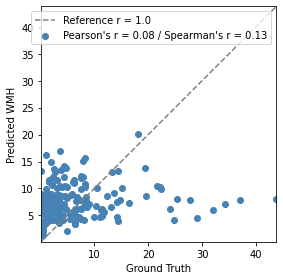

In [20]:
_,_ = predict(model, test_loader)

100%|███████████████████████████████████████████| 51/51 [00:07<00:00,  6.81it/s]


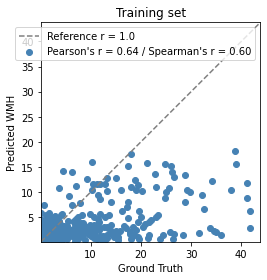

In [21]:
dataset = NeckDataset(train_X, train_y)
data_loader = DataLoader(dataset, batch_size=batch_size, num_workers=16)
_,_ = predict(model, data_loader, 'Training set')

100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.52it/s]


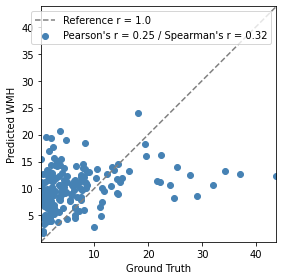

In [22]:
net = SFCN()
net.load_state_dict(torch.load('pretrained/230130_flairWMHvol_sfcn+mae_best'))
net.to(device)
_,_ = predict(net, test_loader)